In [6]:
import sys
import os
import math
import pathlib
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 300
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import EfficientNetV2L

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *
from tensorflow.keras.models import load_model, Model

from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [7]:
train_dir = pathlib.Path('/kaggle/input/brain-tumor-mri-dataset/Training')
test_dir = pathlib.Path('/kaggle/input/brain-tumor-mri-dataset/Testing')
img_height=224
img_width=224

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

# Normalization
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Dataset loading
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,
    interpolation="bilinear",
    label_mode="int",
    follow_links=False,
)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32,
)

val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [9]:
ROOT_DIR = r"/kaggle/input/brain-tumor-mri-dataset"
TRAIN_DIR = os.path.join(ROOT_DIR, 'Training')
TEST_DIR = os.path.join(ROOT_DIR, 'Testing')
assert os.path.isdir(ROOT_DIR) and os.path.isdir(TRAIN_DIR) and os.path.isdir(TEST_DIR)
TUMOR_CLASS = ['meningioma', 'glioma', 'pituitary', 'notumor']
IMAGE_DATA_PATHS = [os.path.join(TRAIN_DIR, tumor_class) for tumor_class in TUMOR_CLASS]
TEST_DATA_PATHS = [os.path.join(TEST_DIR, tumor_class) for tumor_class in TUMOR_CLASS]

# Building Ensemble Model

In [10]:
model_filepath = "/kaggle/input/18-may-ensemble-{epoch:02d}-{val_accuracy:.4f}.keras"
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Ensemble with 3 models

In [7]:
model_inception = load_model('/kaggle/input/model21/keras/models21/1/model1.keras')
model_inception = Model(inputs=model_inception.inputs, outputs=model_inception.outputs, name='model_inception')

model_vgg16 = load_model('/kaggle/input/model21/keras/models21/1/model2.keras')
model_vgg16 = Model(inputs=model_vgg16.inputs, outputs=model_vgg16.outputs, name='model_vgg16')

model_xception = load_model('/kaggle/input/model21/keras/models21/1/model5.keras')
model_xception = Model(inputs=model_xception.inputs, outputs=model_xception.outputs, name='model_xception')

models = [model_inception, model_vgg16, model_xception]

In [8]:
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
flattened_outputs = [tf.nest.flatten(output)[0] if isinstance(output, list) else output for output in model_outputs]

ensemble_output = Average()(flattened_outputs)
ensemble_model_final = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [9]:
ensemble_model_final.compile(
    optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('eensemble_model_final.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

In [11]:
history_final = ensemble_model_final.fit(
    train_ds,
    shuffle=True,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop, model_checkpoint, reduce_lr])

ensemble_model_final.save('ensemble_model_final.keras')

Epoch 1/100


I0000 00:00:1718870056.010176      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718870056.164330      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718870056.169811      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718870056.203213      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.9987 - loss: 0.0955

W0000 00:00:1718870321.306484      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718870321.348387      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9987 - loss: 0.0955   

W0000 00:00:1718870331.899974      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718870331.919039      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718870331.923726      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718870390.012458      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718870390.032087      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


143/143 ━━━━━━━━━━━━━━━━━━━━ 561s 2s/step - accuracy: 0.9986 - loss: 0.0954 - val_accuracy: 0.9895 - val_loss: 0.1068 - learning_rate: 1.0000e-04
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 127s 882ms/step - accuracy: 0.9956 - loss: 0.0805 - val_accuracy: 0.9737 - val_loss: 0.1209 - learning_rate: 1.0000e-04
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 127s 883ms/step - accuracy: 0.9968 - loss: 0.0624 - val_accuracy: 0.9737 - val_loss: 0.1184 - learning_rate: 1.0000e-04
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 142s 883ms/step - accuracy: 0.9958 - loss: 0.0539 - val_accuracy: 0.9729 - val_loss: 0.1101 - learning_rate: 1.0000e-04
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 127s 886ms/step - accuracy: 0.9979 - loss: 0.0479 - val_accuracy: 0.9764 - val_loss: 0.1070 - learning_rate: 1.0000e-04
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 131s 909ms/step - accuracy: 0.9946 - loss: 0.0537 - val_accuracy: 0.9834 - val_loss: 0.0771 - learning_rate: 1.0000e-04
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 127s 883

In [12]:
ensemble_evaluation = ensemble_model_final.evaluate(test_ds)
print(f'Test accuracy: {ensemble_evaluation[1]*100:.2f}%')

40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.9859 - loss: 0.0443

W0000 00:00:1718879568.702931      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718879568.722136      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718879568.727032      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9859 - loss: 0.0440 
Test accuracy: 98.70%


In [15]:
ensemble_model_final = load_model('/kaggle/input/20-june/eensemble_model_final.keras')

In [16]:
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.extend(images.numpy())
    test_labels.extend(labels.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)


In [17]:
y_pred_final = ensemble_model_final.predict(test_images)
y_pred_classes_f = np.argmax(y_pred_final, axis=1) if y_pred_final.shape[1] > 1 else (y_pred_final > 0.5).astype("int32")

# Extract class names from the directory structure
class_names = sorted([item.name for item in test_dir.glob('*/') if item.is_dir()])

# Generate the classification report
report_f = classification_report(test_labels, y_pred_classes_f, target_names=class_names)
print("Classification Report:")
print(report_f)

 1/41 ━━━━━━━━━━━━━━━━━━━━ 41:54 63s/step

I0000 00:00:1718891902.289822     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718891902.343660     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718891902.362693     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718891902.367426     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step


W0000 00:00:1718891978.832678     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718891978.851846     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.98      0.99       300
  meningioma       0.98      0.98      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



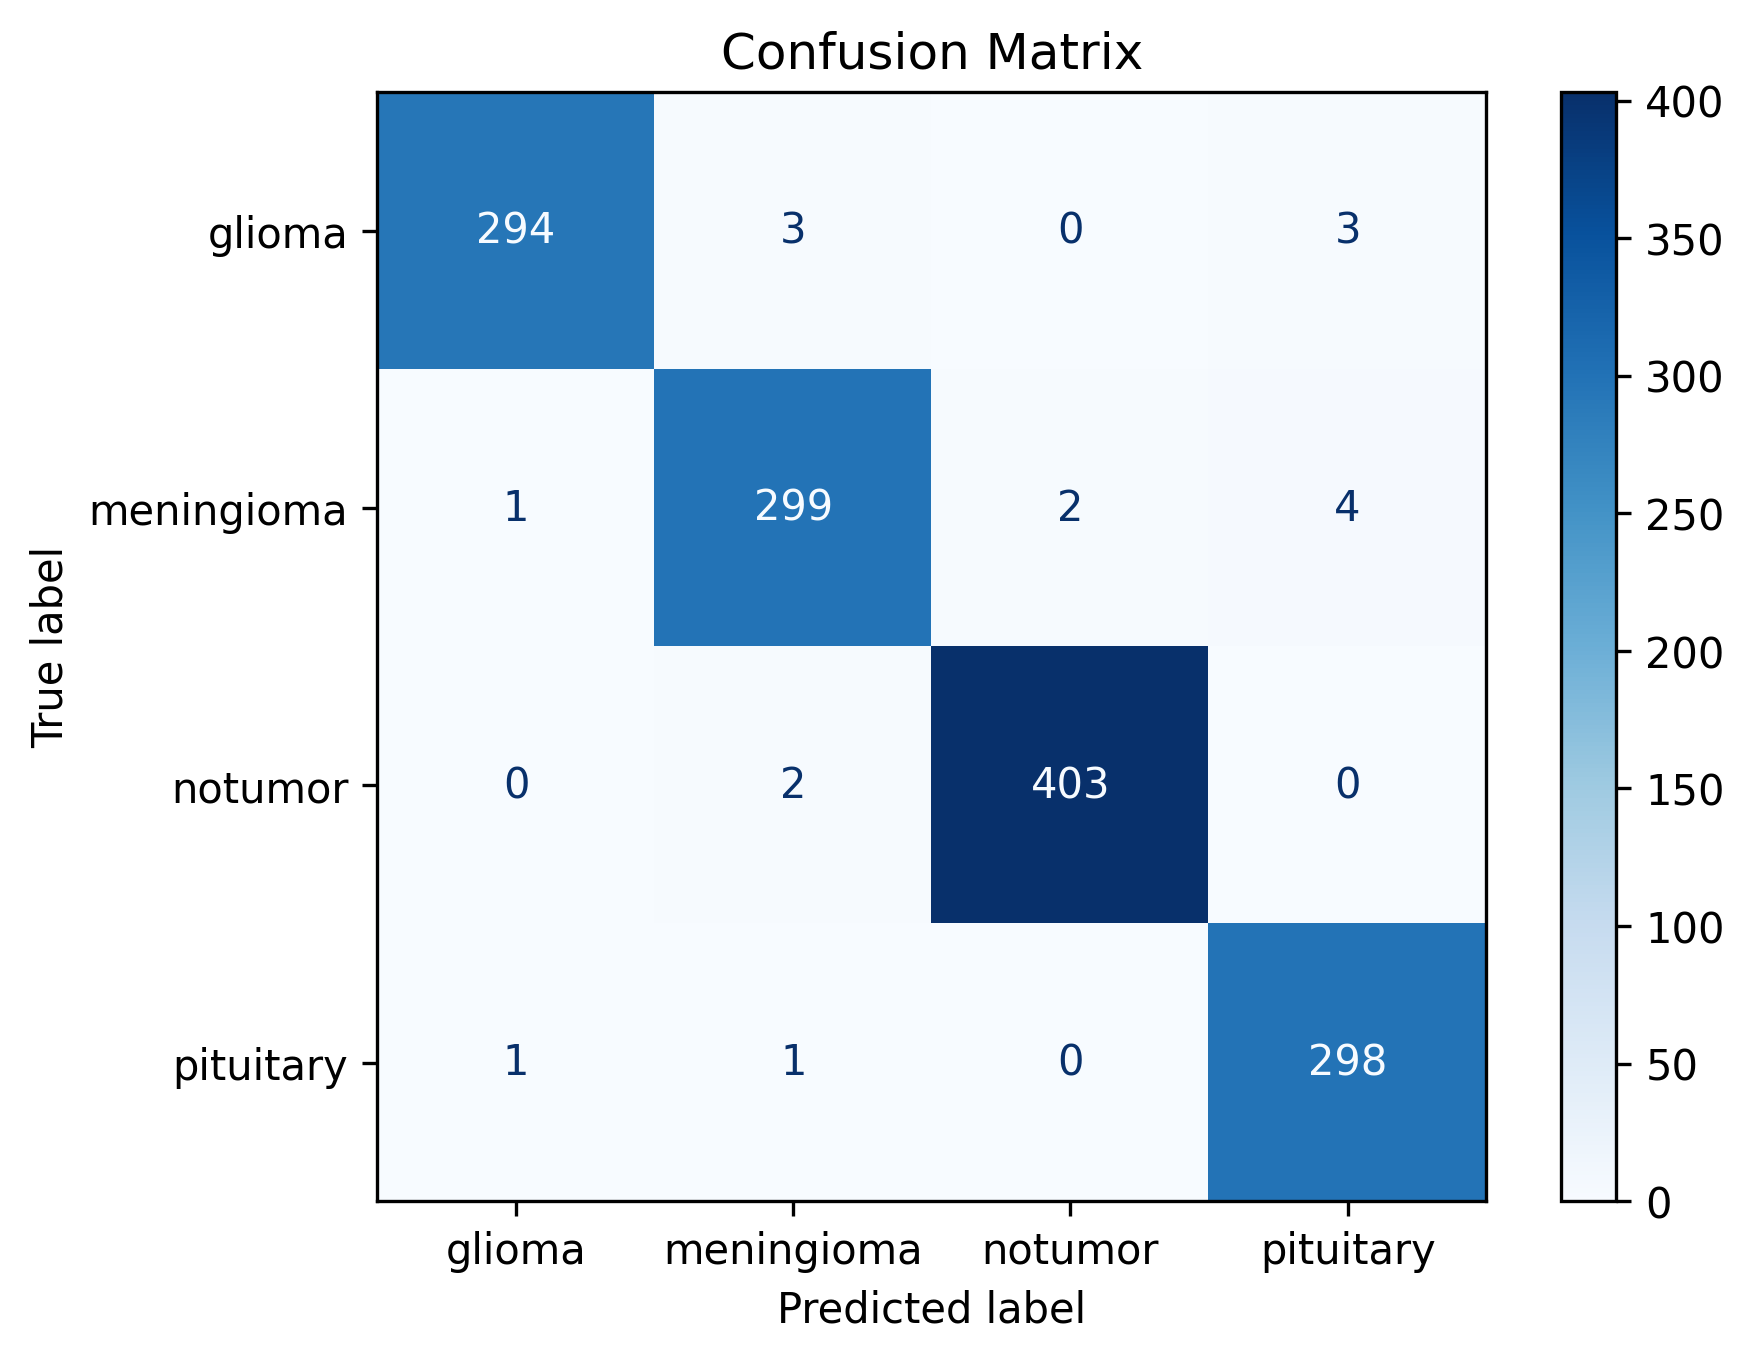

In [18]:
cm = confusion_matrix(test_labels, y_pred_classes_f)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()